Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


Loading the Dataset

In [2]:
df = pd.read_csv("data.csv")
df.columns = [c.strip() for c in df.columns]  

print("Shape:", df.shape)
df.head()


Shape: (118, 20)


,atomicNumber,symbol,name,atomicMass,cpkHexColor,electronicConfiguration,electronegativity,atomicRadius,ionRadius,vanDelWaalsRadius,ionizationEnergy,electronAffinity,oxidationStates,standardState,bondingType,meltingPoint,boilingPoint,density,groupBlock,yearDiscovered
0,1,H,Hydrogen,1.00794(4),FFFFFF,1s1,2.20,37.0,NaN,120.0,1312.0,-73.0,"-1, 1",gas,diatomic,14.0,20.0,0.000090,nonmetal,1766
1,2,He,Helium,4.002602(2),D9FFFF,1s2,NaN,32.0,NaN,140.0,2372.0,0.0,NaN,gas,atomic,NaN,4.0,0.000179,noble gas,1868
2,3,Li,Lithium,6.941(2),CC80FF,[He] 2s1,0.98,134.0,76 (+1),182.0,520.0,-60.0,1,solid,metallic,454.0,1615.0,0.535000,alkali metal,1817
3,4,Be,Beryllium,9.012182(3),C2FF00,[He] 2s2,1.57,90.0,45 (+2),NaN,900.0,0.0,2,solid,metallic,1560.0,2743.0,1.848000,alkaline earth metal,1798
4,5,B,Boron,10.811(7),FFB5B5,[He] 2s2 2p1,2.04,82.0,27 (+3),NaN,801.0,-27.0,"1, 2, 3",solid,covalent network,2348.0,4273.0,2.460000,metalloid,1807


Dataset Exploration and Summary Statistics

In [3]:
df.info()
df.describe(include="all")

unique_counts = df.nunique(dropna=False).sort_values(ascending=False)
print(unique_counts)


missing = df.isna().sum().sort_values(ascending=False)
print("Missing values:")
print(missing[missing > 0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   atomicNumber             118 non-null    int64  
 1   symbol                   118 non-null    object 
 2   name                     118 non-null    object 
 3   atomicMass               118 non-null    object 
 4   cpkHexColor              109 non-null    object 
 5   electronicConfiguration  118 non-null    object 
 6   electronegativity        97 non-null     float64
 7   atomicRadius             71 non-null     float64
 8   ionRadius                92 non-null     object 
 9   vanDelWaalsRadius        38 non-null     float64
 10  ionizationEnergy         102 non-null    float64
 11  electronAffinity         85 non-null     float64
 12  oxidationStates          101 non-null    object 
 13  standardState            99 non-null     object 
 14  bondingType              9

Cleaning Numeric Columns Stored as Text

In [5]:
def extract_first_number(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    m = re.search(r"[-+]?\d*\.?\d+", s)
    return float(m.group()) if m else np.nan

for col in ["atomicMass", "ionRadius", "yearDiscovered"]:
    if col in df.columns:
        df[col] = df[col].apply(extract_first_number)

df[["atomicMass","ionRadius","yearDiscovered"]].head()


,atomicMass,ionRadius,yearDiscovered
0,1.007940,NaN,1766.0
1,4.002602,NaN,1868.0
2,6.941000,76.0,1817.0
3,9.012182,45.0,1798.0
4,10.811000,27.0,1807.0


Removing Irrelevant Features

In [6]:
drop_cols = ["name", "symbol", "electronicConfiguration", 
             "oxidationStates", "cpkHexColor"]

df_model = df.drop(columns=[c for c in drop_cols if c in df.columns])

target_col = "groupBlock"   

X = df_model.drop(columns=[target_col])
y = df_model[target_col]

X.head(), y.value_counts()


(   atomicNumber  atomicMass  electronegativity  atomicRadius  ionRadius  \
 0             1    1.007940               2.20          37.0        NaN   
 1             2    4.002602                NaN          32.0        NaN   
 2             3    6.941000               0.98         134.0       76.0   
 3             4    9.012182               1.57          90.0       45.0   
 4             5   10.811000               2.04          82.0       27.0   
 
    vanDelWaalsRadius  ionizationEnergy  electronAffinity standardState  \
 0              120.0            1312.0             -73.0           gas   
 1              140.0            2372.0               0.0           gas   
 2              182.0             520.0             -60.0         solid   
 3                NaN             900.0               0.0         solid   
 4                NaN             801.0             -27.0         solid   
 
         bondingType  meltingPoint  boilingPoint   density  yearDiscovered  
 0          d

Handling Missing Values

In [7]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

for c in num_cols:
    X[c] = X[c].fillna(X[c].mean())

for c in cat_cols:
    X[c] = X[c].fillna(X[c].mode()[0])

y = y.fillna(y.mode()[0])


Encoding Categorical Features

In [8]:
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=False)
print("Encoded shape:", X_enc.shape)


Encoded shape: (118, 19)


Train–Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.30, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(82, 19) (36, 19)


Model Implementation and Training

In [10]:
svm_model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", SVC(kernel="rbf", C=5, gamma="scale"))
])

svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)


In [11]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)


In [12]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=400)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)


Model Performance Evaluation

In [13]:
results = pd.DataFrame({
    "Model": ["SVM", "Decision Tree", "Random Forest"],
    "Accuracy": [svm_acc, dt_acc, rf_acc]
})

print(results)


           Model  Accuracy
0            SVM  0.444444
1  Decision Tree  0.750000
2  Random Forest  0.833333


Visualization of Model Results

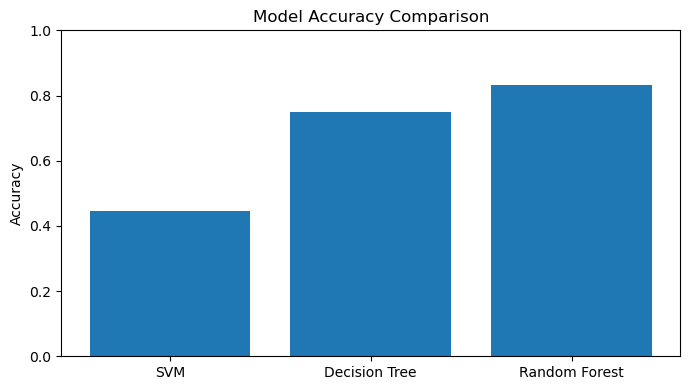

In [14]:
plt.figure(figsize=(7,4))
plt.bar(results["Model"], results["Accuracy"])
plt.ylim(0,1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


Best Model Report

In [15]:
best_model = results.sort_values("Accuracy", ascending=False).iloc[0]["Model"]
print("Best model:", best_model)

if best_model == "Random Forest":
    print(classification_report(y_test, rf_preds))
elif best_model == "Decision Tree":
    print(classification_report(y_test, dt_preds))
else:
    print(classification_report(y_test, svm_preds))


Best model: Random Forest
                       precision    recall  f1-score   support

             actinoid       1.00      1.00      1.00         4
         alkali metal       1.00      1.00      1.00         2
 alkaline earth metal       0.67      1.00      0.80         2
              halogen       0.00      0.00      0.00         2
           lanthanoid       1.00      1.00      1.00         5
                metal       1.00      0.50      0.67         2
            metalloid       0.00      0.00      0.00         2
            noble gas       1.00      0.50      0.67         2
             nonmetal       0.50      1.00      0.67         2
post-transition metal       0.50      1.00      0.67         1
     transition metal       0.92      1.00      0.96        12

             accuracy                           0.83        36
            macro avg       0.69      0.73      0.68        36
         weighted avg       0.80      0.83      0.80        36



c:\Users\HP\anaconda3\envs\MLAssignment\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HP\anaconda3\envs\MLAssignment\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HP\anaconda3\envs\MLAssignment\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 